# Introduction: Cheff

This notebook is a tutorial on how to load the Cheff Pipeline and synthesize Chest X-rays.
Keep in mind that for an optimal user experience a GPU with at least 8GB VRAM is recommended.

In [1]:
import os
os.chdir('..')

import torch
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image, to_grayscale, to_tensor

## Cheff LDM Module

The Cheff LDM Module contains Phase 1 and 2 combined.


In [2]:
from cheff import CheffLDM

device = 'cuda'
sdm_path = 'trained_models/cheff_diff_uncond.pt'
ae_path = 'trained_models/cheff_autoencoder.pt'

cheff_ldm = CheffLDM(model_path=sdm_path, ae_path=ae_path, device=device)

The path to the autoencoder is optional. In case of no supplied `ae_path`, the autoencoder will be initialized with random weights.

A sample with a resolution of 256 pixels can be generated with the `sample` function.

Data shape for DDIM sampling is (3, 3, 64, 64), eta 1.0
Running DDIM Sampling with 100 timesteps


DDIM Sampler: 100%|█████████████████████████| 100/100 [00:09<00:00, 11.11it/s]


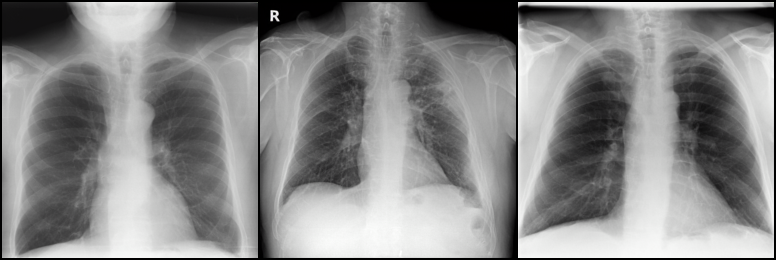

In [3]:
imgs = cheff_ldm.sample(
    # Number of images to synthesize
    batch_size=3,
    # Number of DDIM sampling steps
    sampling_steps=100,
    # eta in DDIM sampling
    eta=1.0,
    # Use the AE decoder to translate from latent space.
    decode=True
)

# The image are still in [-1, 1] so they need to be rescaled.
imgs.clamp_(-1, 1)
imgs = (imgs + 1) / 2

# Show the produced images
grid = make_grid(imgs.cpu())
to_pil_image(grid)

If `decode` is set to `False`, the function returns the latent embedding of the synthesized sample.

## Cheff AE Module

The autoencoder can also be loaded as a separate module, which is able to encode and decode images.

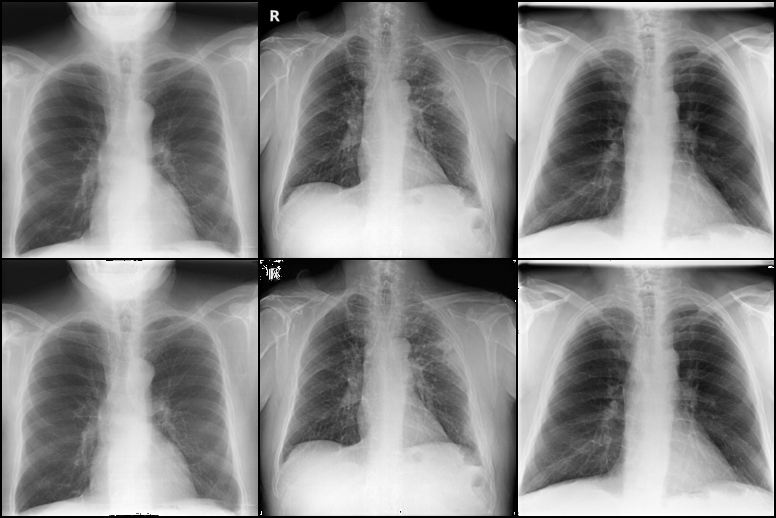

In [4]:
from cheff import CheffAEModel

device = 'cuda'
ae_path = 'trained_models/cheff_autoencoder.pt'

cheff_ae = CheffAEModel(model_path=ae_path, device=device)

# Encode images to latent space
z = cheff_ae.encode(imgs)

# Reconstruct images
imgs_rec = cheff_ae.decode(z)

# Check reconstruction quality
imgs_grid = torch.cat([imgs, imgs_rec]).cpu()
imgs_grid = torch.stack([to_tensor(to_grayscale(to_pil_image(i))) for i in imgs_grid])
grid = make_grid(imgs_grid, nrow=len(imgs))
to_pil_image(grid)

## Cheff SR Module

The super-resolution module follows a similar interface as the other two models.
Note that this models works on a grayscale basis, whereas the rest of this stack still uses an RGB input.
Running SR with the full DDPM denoising steps delivers the best results, but takes a lot of time and compute compared to DDIM sampling.
When setting `ddim` as method the arguments `sampling_steps` and `eta` can be specified like in `CheffLDM`.

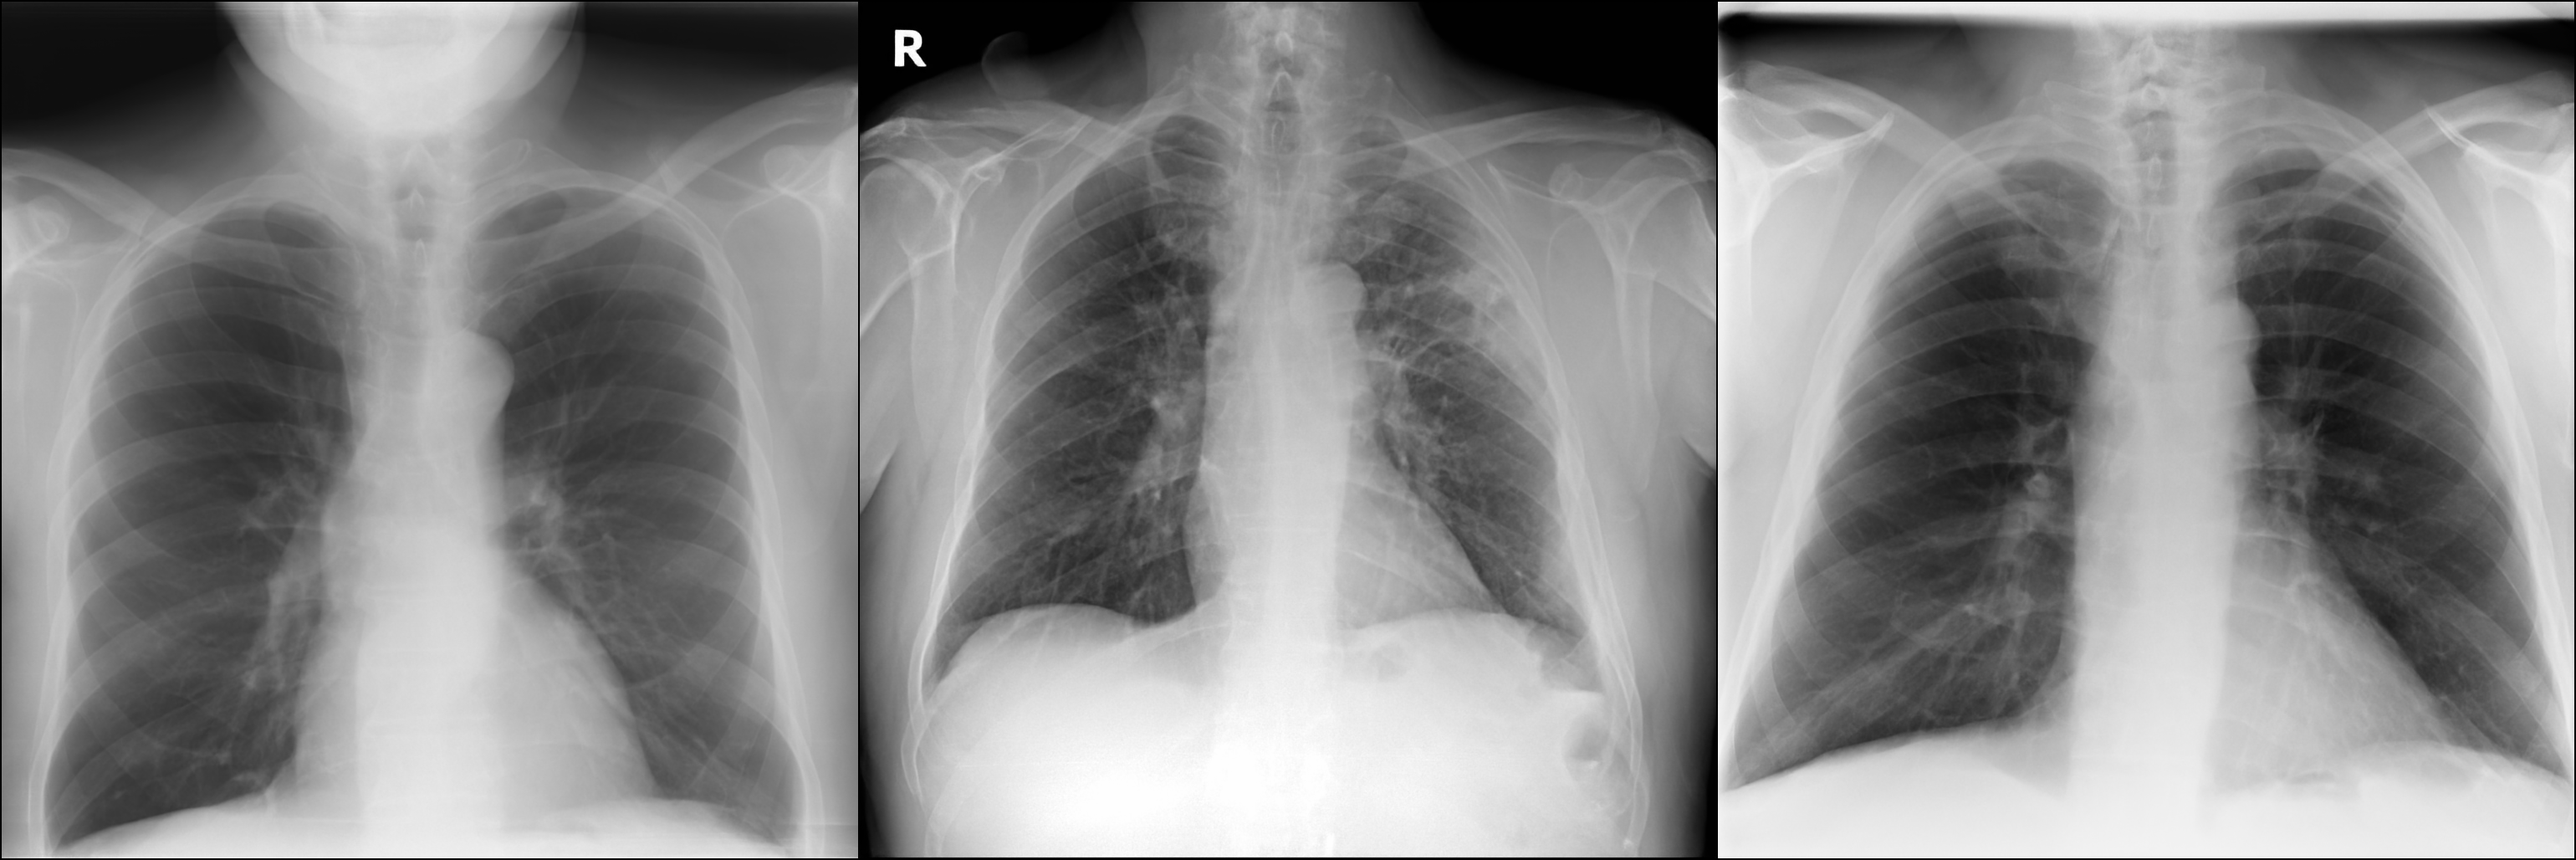

In [5]:
from cheff import CheffSRModel

device = 'cuda'
sr_path = 'trained_models/cheff_sr_fine.pt'

cheff_sr = CheffSRModel(model_path=sr_path, device=device)

# Convert to grayscale
imgs = torch.stack([to_tensor(to_grayscale(to_pil_image(i))) for i in imgs])

# Predict super resolution image
imgs_sr = cheff_sr.sample(
    img=imgs,
    method='ddpm'
)

grid = make_grid(imgs_sr.cpu())
to_pil_image(grid)

Apart from directly converting tensors, the SR model also allows to directly upsample paths and directories.

In [7]:
# Upscale image from path.
#img_path = 'path/to/image.png'
#imgs_sr = cheff_sr.sample_path(path=img_path, method='ddpm')

# Upscale a full directory
#cheff_sr.sample_directory(
#    # Take images from here
#    source_dir='path/to/sourcedir',
#    # The resulting images will be saved here
#    target_dir='path/to/targetdir',
#    # Batch size in SR model
#    batch_size=4,
#)

## Report-to-Chest X-ray Synthesis

For the text-conditional synthesis task, we offer an extra module `CheffLDMT2I`

Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 100 timesteps


DDIM Sampler: 100%|█████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


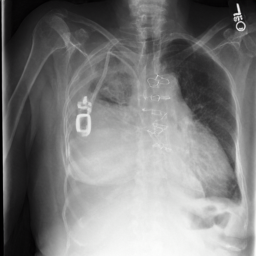

In [9]:
from cheff import CheffLDMT2I

device = 'cpu'
sdm_path = 'trained_models/cheff_diff_t2i.pt'
ae_path = 'trained_models/cheff_autoencoder.pt'

cheff_t2i = CheffLDMT2I(model_path=sdm_path, ae_path=ae_path, device=device)

prompt = 'Large right-sided pleural effusion.'

img = cheff_t2i.sample(
    conditioning=prompt,
    sampling_steps=100,
    eta=1.0,
    decode=True
)

img.clamp_(-1, 1)
img = (img + 1) / 2
to_pil_image(img[0])